In [13]:
%%capture
pip install tensorflow

In [45]:
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, callbacks

In [27]:
# Define your 3 zip files and the destination
zip_files = ['Bacterial leaf blight-20200814T055237Z-001.zip', 'Brown spot-20200814T055208Z-001.zip', 'Leaf smut-20200814T055530Z-001.zip']
main_data_dir = './rice_leaf_dataset'

if not os.path.exists(base_extract_path):
    os.makedirs(base_extract_path)

# 2. Loop and extract each one
for zip_name in zip_files:
    if os.path.exists(zip_name):
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            # This extracts the contents into a subfolder named after the zip
            # e.g., ./rice_data_local/Bacterial_Blight
            folder_name = zip_name.replace('.zip', '')
            target_dir = os.path.join(base_extract_path, folder_name)
            zip_ref.extractall(target_dir)
            print(f"Successfully extracted {zip_name} into {target_dir}")
    else:
        print(f"Warning: {zip_name} not found in current directory!")

Successfully extracted Bacterial leaf blight-20200814T055237Z-001.zip into ./Riceleafcnn\Bacterial leaf blight-20200814T055237Z-001
Successfully extracted Brown spot-20200814T055208Z-001.zip into ./Riceleafcnn\Brown spot-20200814T055208Z-001
Successfully extracted Leaf smut-20200814T055530Z-001.zip into ./Riceleafcnn\Leaf smut-20200814T055530Z-001


In [29]:
classes = os.listdir(base_extract_path)
print(f"Detected Classes: {classes}")

for cls in classes:
    path = os.path.join(base_extract_path, cls)
    if os.path.isdir(path):
        # Count images inside (including subfolders if the zip had them)
        img_count = sum([len(files) for r, d, files in os.walk(path)])
        print(f" - {cls}: {img_count} images found")

Detected Classes: ['Bacterial leaf blight-20200814T055237Z-001', 'Brown spot-20200814T055208Z-001', 'Leaf smut-20200814T055530Z-001']
 - Bacterial leaf blight-20200814T055237Z-001: 40 images found
 - Brown spot-20200814T055208Z-001: 40 images found
 - Leaf smut-20200814T055530Z-001: 39 images found


In [41]:
# 2. DATA AUGMENTATION (Crucial for Small Data)
# ==========================================
BATCH_SIZE = 8  # Small batch size for better learning on small data
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      # High rotation for varied angles
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2    # 20% for validation
)

print("\n--- Loading Data ---")
train_generator = train_datagen.flow_from_directory(
    main_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    main_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


--- Loading Data ---
Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


In [47]:
# 3. BUILD MODEL (MobileNetV2 Transfer Learning)
# ==========================================
# We use MobileNetV2 because it is fast and accurate for agricultural tasks
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False # Freeze base to keep pre-trained knowledge

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Heavily penalize memorization
    layers.Dense(3, activation='softmax') # 3 Output Neurons for the 3 Diseases
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
# 4. TRAIN WITH CALLBACKS
# ==========================================
# Stop training if accuracy doesn't improve for 5 epochs
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n--- Starting Training ---")
history = model.fit(
    train_generator,
    epochs=25, # Max epochs (early_stop will cut it short if needed)
    validation_data=validation_generator,
    callbacks=[early_stop]
)


--- Starting Training ---
Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4375 - loss: 1.6807 - val_accuracy: 0.6957 - val_loss: 0.6618
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step - accuracy: 0.6562 - loss: 0.8009 - val_accuracy: 0.9130 - val_loss: 0.3659
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 676ms/step - accuracy: 0.7917 - loss: 0.5463 - val_accuracy: 0.8261 - val_loss: 0.4952
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 754ms/step - accuracy: 0.8021 - loss: 0.4711 - val_accuracy: 0.8261 - val_loss: 0.5808
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 768ms/step - accuracy: 0.8958 - loss: 0.3334 - val_accuracy: 0.8261 - val_loss: 0.4292
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 763ms/step - accuracy: 0.8958 - loss: 0.3059 - val_accuracy: 0.8261 - val_loss: 0.3097
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 753ms/step - accuracy: 0.9375 - loss: 0.2165 - val_accuracy: 0.9130 - val_loss: 0.2488
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 756ms/step - accuracy: 0.9271 - 


 Model saved as 'Rice_Disease_Model.h5'


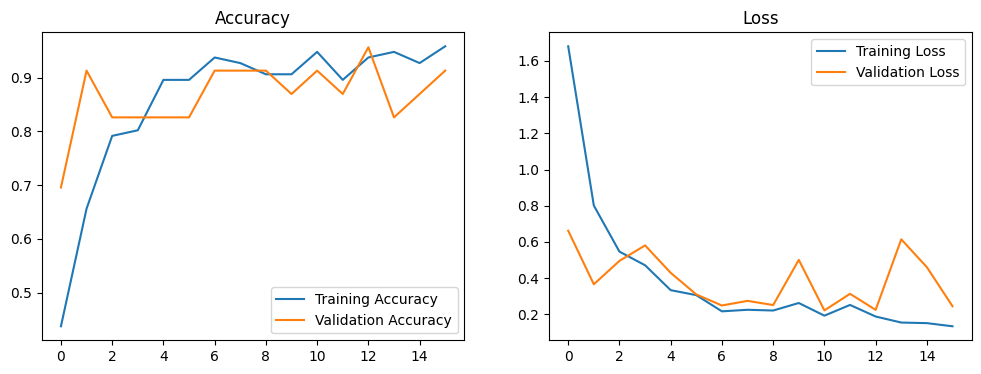

In [51]:
# 5. SAVE & VISUALIZE
# ==========================================
model.save('Rice_Disease_Model.h5')
print("\n Model saved as 'Rice_Disease_Model.h5'")

# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()